In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import glob
from pathlib import Path

# Import Data

In [19]:
# Charger les données segmentées
oiseau = "Dactyl/"
# BRA_ABR_2019_02  BRA_ABR_2020_02  BRA_ABR_2021_05  BRA_ABR_2022_08  BRA_ABR_2023_09  
path = "BRA_ABR_2019_02/"
csv_files_seg = glob.glob("Data_segmented_completed/"+path+"by_dist/"+oiseau+"*.csv")
# csv_files_seg = glob.glob("Data_segmented/*/by_dist/"+oiseau+"*.csv")

# lieu = "BRA_ABR"
# oiseau = "SDAC"
# periode = "*/"
# csv_files_seg = glob.glob("Data_segmented_GPS/"+lieu+"/"+oiseau+"/"+periode+"by_dist/*.csv")

new_size = 50
save_path = "Data_segmented_completed_with_features_reshaped/"+path+str(new_size)+"nodes/"+oiseau
# save_path = "Data_segmented_GPS_reshaped/"+lieu+"/"+oiseau+"/by_dist/"  # Path to the folder where the segmented data will be stored

df_list = []
for file in csv_files_seg:
    df = pd.read_csv(file)
    df_list.append(df)
# df_list = df_list[:20]
print(df_list[0])

       ax    ay    az  pressure  temperature    lat    lon  height.msl  \
0    0.44  0.25  1.56   1030.17         25.5 -17.96 -38.69      -98.00   
1    0.56 -0.12  1.94   1030.43         25.6 -17.95 -38.69       56.00   
2    0.12  0.12  0.31   1030.86         25.7 -17.95 -38.68       12.00   
3    0.14  0.01  0.41   1030.56         25.8 -17.94 -38.68        4.55   
4    0.81  0.06  2.13   1029.98         25.9 -17.94 -38.67       -8.00   
..    ...   ...   ...       ...          ...    ...    ...         ...   
813  0.93  0.84  2.69   1026.20         26.0 -17.95 -38.65       -1.60   
814  0.97 -0.04  1.76   1025.30         26.0 -17.96 -38.65       27.09   
815  0.11 -0.01 -1.18   1023.77         25.9 -17.96 -38.66       72.20   
816  0.03 -0.34  0.10   1024.49         25.9 -17.97 -38.67       44.67   
817  0.29  0.62  1.43   1024.74         25.9 -17.97 -38.68       58.20   

     ground.speed  satellites  ...  gaps  step_speed  step_direction  \
0           48.20         3.0  ...  0.0

# Reshape Data

## Analyse

1998
91


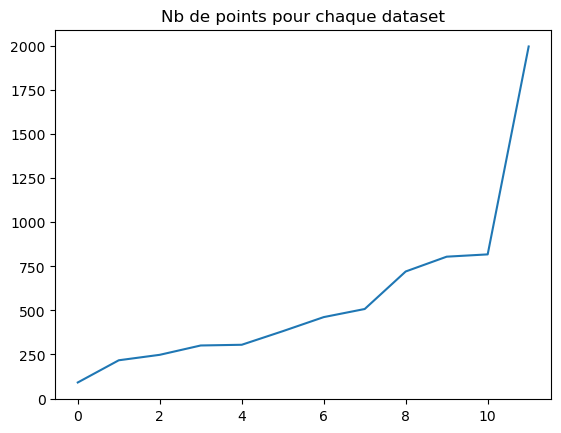

In [20]:
# df_list = [df[["lon", "lat", 'time', 'date']] for df in df_list]

print(max(df.shape[0] for df in df_list))
print(min(df.shape[0] for df in df_list))

sorted_df_list = sorted(df_list, key=lambda x: x.shape[0])
sorted_df_list = [df.shape[0] for df in sorted_df_list]
plt.title("Nb de points pour chaque dataset")
# On ne garde que les valeurs plus petites que 2000
sorted_df_list = np.array(sorted_df_list)
plt.plot(sorted_df_list)
# plt.plot(sorted_df_list[sorted_df_list < 2000])

La durée maximale est de 
119820.0
soit en heures : 
33.28333333333333
Stats
Mean:  34220.0
Median:  25260.0
Std:  29136.907866141184


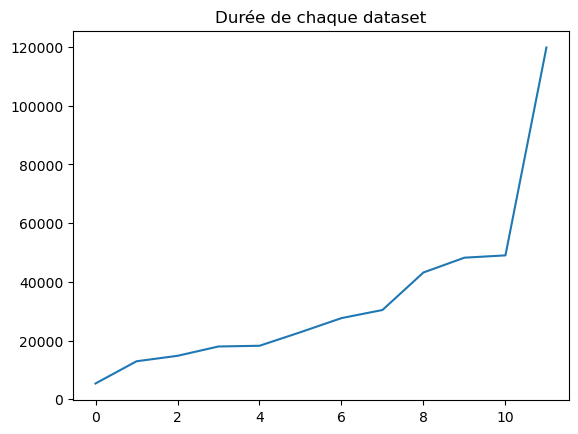

In [21]:
durations = np.zeros(len(df_list))

for i, df in enumerate(df_list):
    # try:
    #     df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d-%m-%Y %H:%M:%S.%f')
    # except ValueError:
    #     try:
    #         df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S.%f')
    #     except ValueError:
    #         raise ValueError("Unknown date format in the dataset.")
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.sort_values('datetime', inplace=True)    
    duration_timedelta = df['datetime'].max() - df['datetime'].min()
    durations[i] = duration_timedelta.total_seconds()  # Convert timedelta to seconds


durations = sorted(durations)

plt.figure()
plt.title("Durée de chaque dataset")
plt.plot(durations)

print("La durée maximale est de ")
print(max(durations))
print("soit en heures : ")
print(max(durations) / 3600)
print("Stats")
print("Mean: ",np.mean(durations))
print("Median: ",np.median(durations))
print("Std: ",np.std(durations))


## Sélection

On ne va donc garder que les df contenant plus de 200, et compris dans une seule journée (réduction simplificatrice pour l'instant)

In [22]:
# df_list = [df for df in df_list if 200 < df.shape[0]]
# print(len(df_list))

# # Retirons les datasets qui s'étalent sur plusieurs jours
# df_list = [df for df in df_list if df['date'].iloc[0] == df['date'].iloc[-1]]
# print(len(df_list))

# # Regardons la durée de chacun de ces datasets
# durations = [df['time'].iloc[-1] - df['time'].iloc[0] for df in df_list]
# durations = [d.total_seconds() for d in durations]
# plt.plot(durations)

## Uniformisation des formats

Pour entraîner des GNN, il est généralement plus pratique d'avoir le même nombre de point pour chaque df

In [23]:
def resize_dataframe(df, new_size=new_size, step=0):
    # Calculate the current number of positions
    df = df[5*step:]
    current_size = len(df['lon'])
        
    # Interpolate or resample the DataFrame to fit the new size
    if current_size > new_size :
        indices = np.linspace(0, current_size - 1, new_size, dtype=int)
        resized_df = df.iloc[indices]
    else:
        new_index = pd.RangeIndex(start=0, stop=new_size)
        resized_df = df.reindex(new_index)
        resized_df = resized_df.interpolate(method='linear')  # Use linear interpolation
    resized_df = resized_df.reset_index(drop=True)

    if max(resized_df['dist_to_nest'][0], resized_df['dist_to_nest'].iloc[-1]) < 10 :
        return resized_df
    else :
        print("Premier et dernier pas trop éloignés (plus de 10km)")
        return None

# Pour ne pas avoir de chevauchement avec les anciens fichiers :
folder_path = save_path
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
Path(folder_path).mkdir(parents=True, exist_ok=True)

# Resize each DataFrame in the list to have "new_size" positions
resized_dfs = []
# df_list = [df[["lon", "lat", "dist_to_nest"]] for df in df_list]
i = 1
for df in df_list:
    for step in range(1) :                                          # pour prendre des pas décalés, avoir des traj similaires mais un peu décalées
        resized_df = resize_dataframe(df, new_size, step=step)
        if resized_df is not None:
            resized_dfs.append(resized_df)
            filename = f""+save_path+"data_seg_compl_resh_"+str(i)+"_"+str(step)+".csv"
            resized_df.to_csv(filename, index=False)
    i += 1


Trajectoires non restructurées


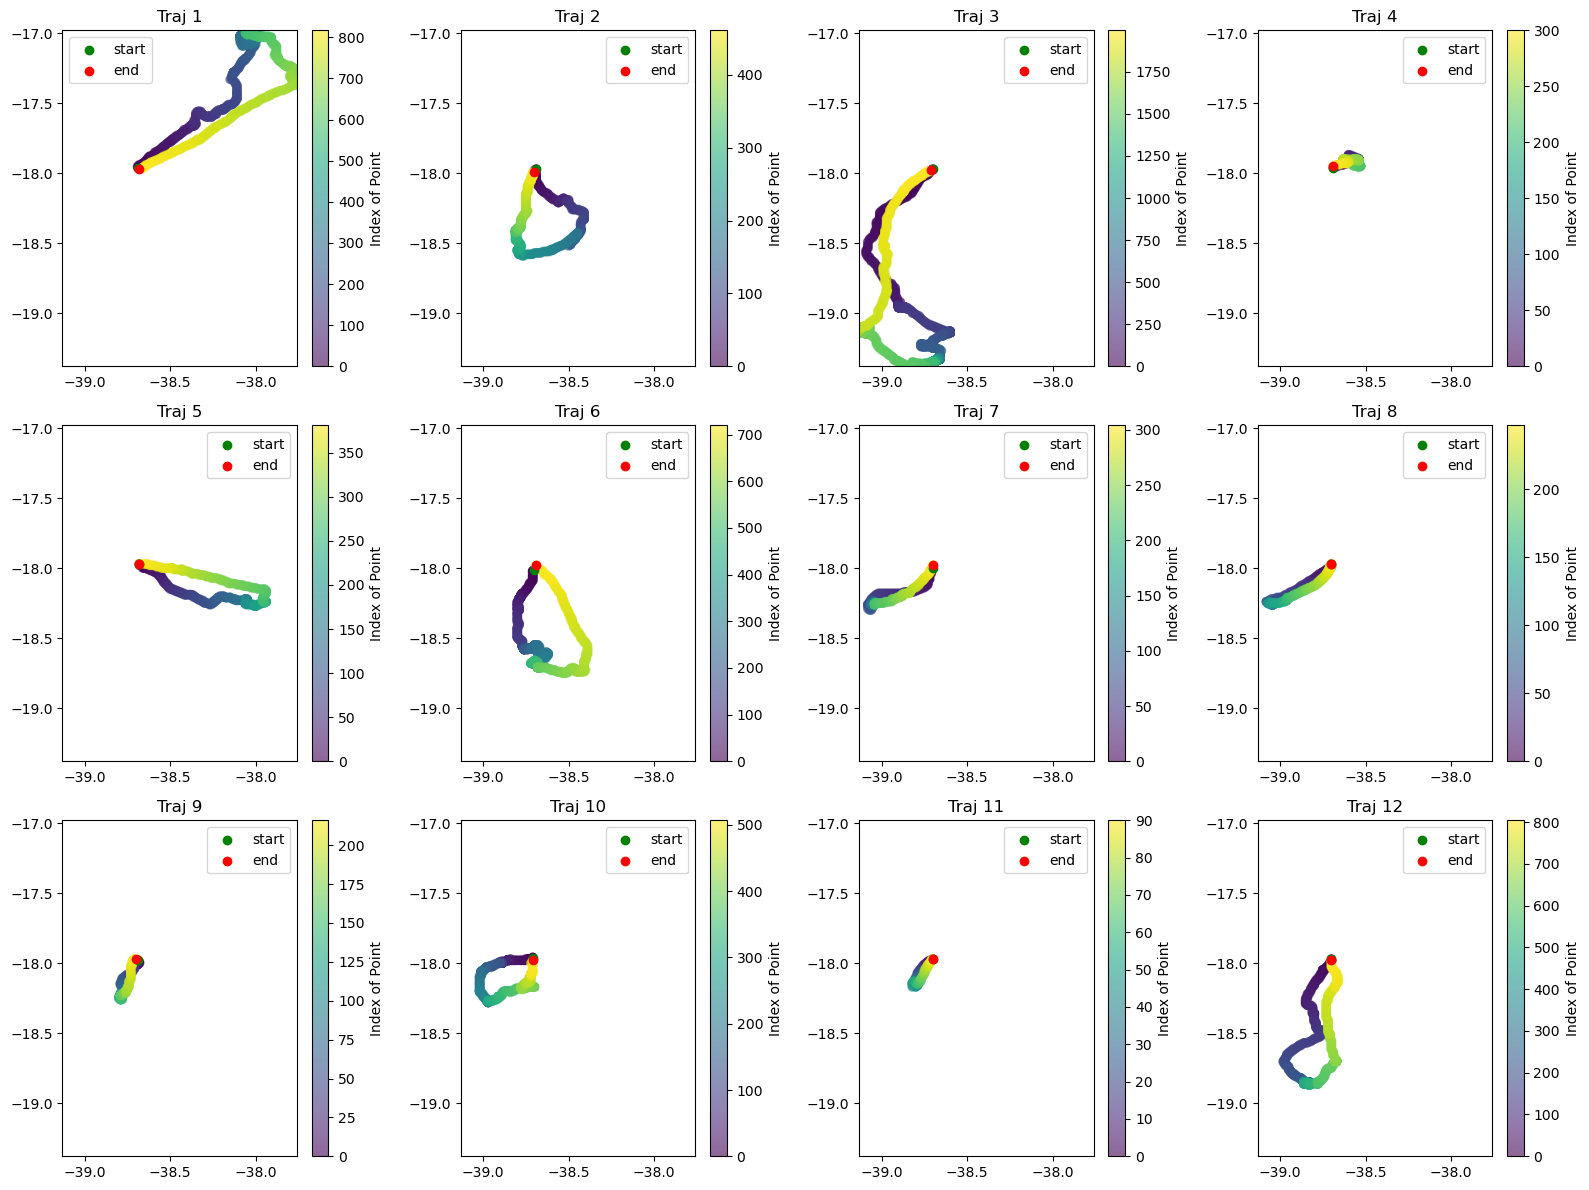

In [24]:
nb = len(df_list)
# nb = min(20, len(df_list))
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df['lon'].values for df in df_list]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df['lat'].values for df in df_list]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        indices = np.arange(len(df_list[i]['lon']))
        norm = plt.Normalize(indices.min(), indices.max())
        cmap = plt.get_cmap('viridis')
        colors = cmap(norm(indices))

        x = df_list[i]['lon']
        y = df_list[i]['lat']

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        
        # Add start and end points
        ax.scatter(x[0], y[0], color='green', label='start')
        ax.scatter(x.iloc[-1], y.iloc[-1], color='red', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')
        
        # Add colorbar to each subplot
        plt.colorbar(scatter, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires non restructurées")
plt.tight_layout()
plt.show()

In [25]:
for i in range(len(resized_dfs)):
    resized_dfs[i]["time_diff"] = resized_dfs[i]["datetime"].diff().dt.total_seconds()

print(resized_dfs[0].shape)
print(resized_dfs[0])

(50, 26)
      ax    ay    az  pressure  temperature    lat    lon  height.msl  \
0   0.44  0.25  1.56   1030.17        25.50 -17.96 -38.69      -98.00   
1   0.36  0.05  1.01   1032.19        24.89 -17.90 -38.63       68.00   
2   0.38  0.00  1.44   1030.40        24.70 -17.85 -38.59       42.00   
3  -0.19  0.01  0.19   1030.74        25.70 -17.78 -38.50      -10.73   
4   0.99  0.69  2.47   1030.71        25.80 -17.71 -38.43        0.60   
5   0.09 -0.17  0.84   1028.94        24.50 -17.65 -38.36        3.00   
6   0.06  0.00  0.88   1030.46        24.00 -17.65 -38.37       12.00   
7  -0.19  1.06  0.49   1033.45        25.18 -17.56 -38.33      -10.31   
8   0.14  0.35  1.17   1030.08        25.20 -17.60 -38.26      -10.40   
9   0.08  0.08  1.44   1233.26        25.30 -17.55 -38.20      -23.65   
10  0.26  0.11  1.19   1032.30        25.40 -17.51 -38.16       -8.00   
11  0.00  0.81  1.06   1028.88        26.00 -17.42 -38.11       -2.00   
12 -0.12  0.19  0.78   1031.91        26.3

### Visualisation avec les points

Trajectoires restructurées


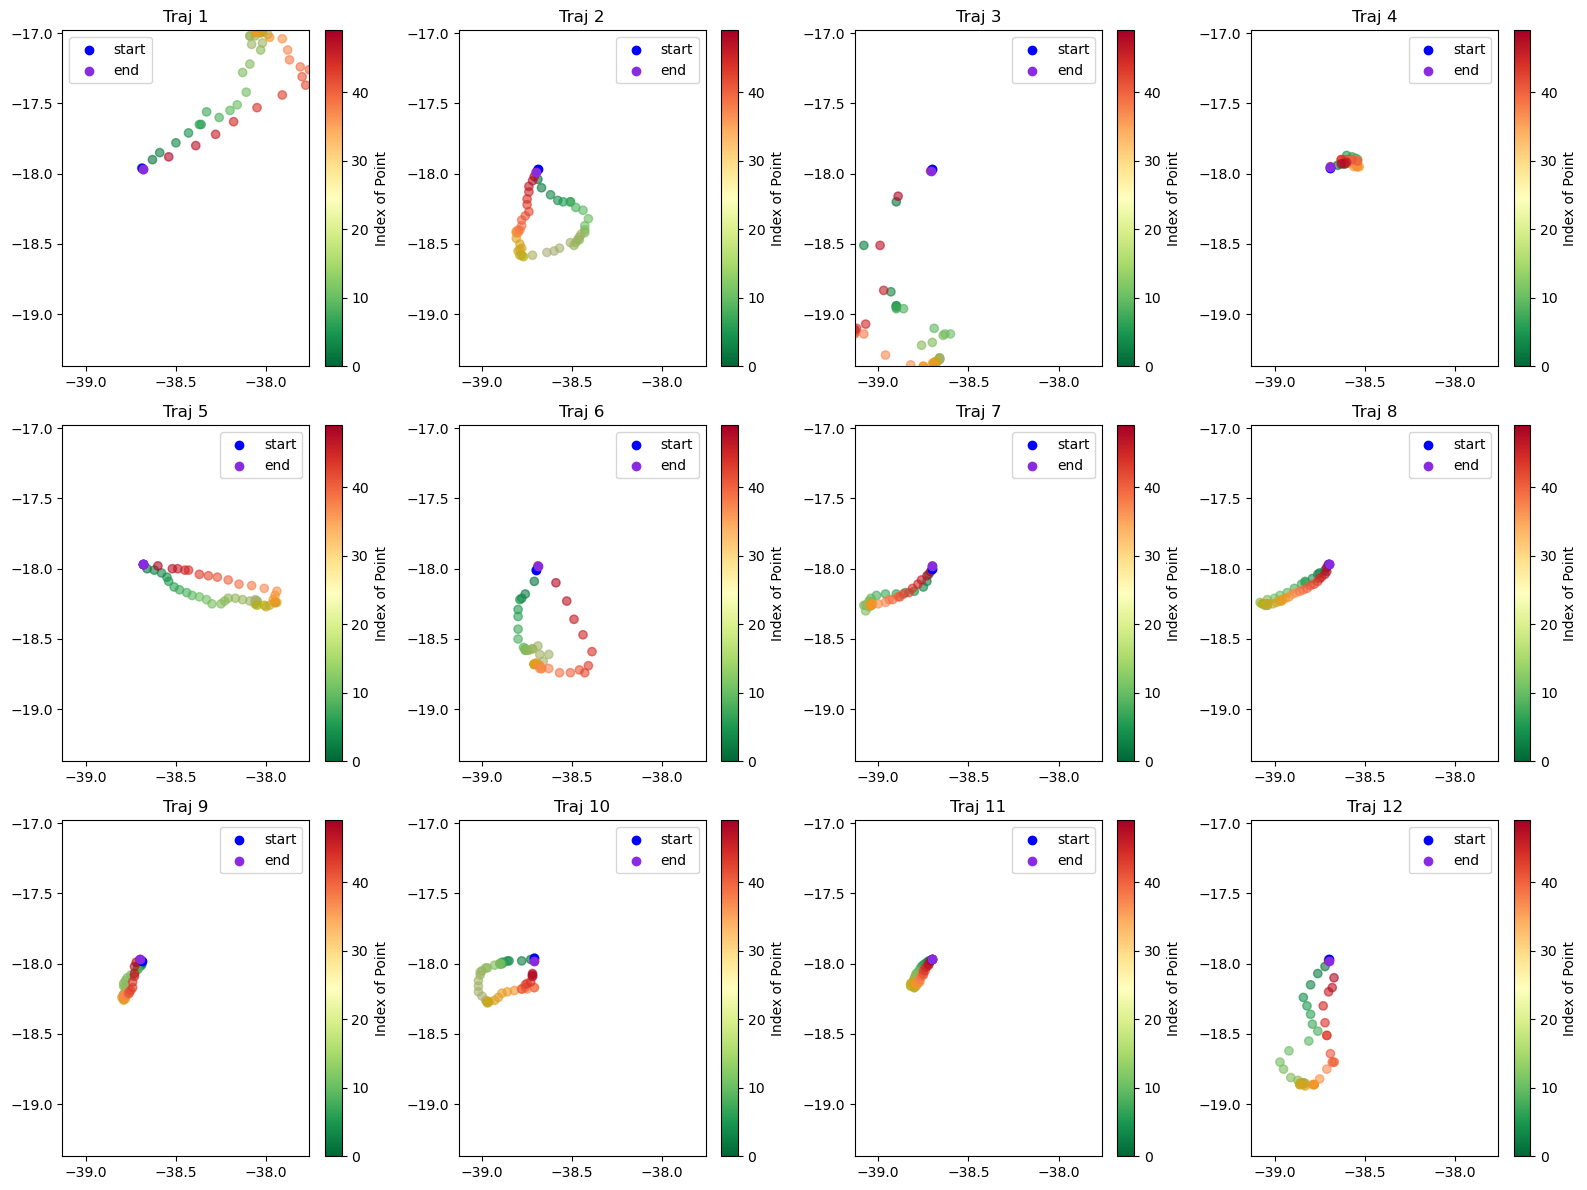

In [26]:
nb = len(resized_dfs)
# nb = 5
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df['lon'].values for df in resized_dfs]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df['lat'].values for df in resized_dfs]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# indices = np.arange(len(resized_dfs[0]['lon']))
# norm = plt.Normalize(indices.min(), indices.max())
# cmap = plt.get_cmap('viridis')
# colors = cmap(norm(indices))

import hsluv
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

index = np.arange(new_size)
# cmap = plt.cm.get_cmap('RdYlGn_r')  # Red to green colormap
cmap = plt.colormaps['RdYlGn_r']
cmap.set_under('black')
colors = cmap(index / max(index))
hex_colors = [mcolors.to_hex(c) for c in colors]
hsluv_colors = [hsluv.hex_to_hsluv(c) for c in hex_colors]
colors = [hsluv.hsluv_to_hex((h, s, min(l, 70))) for h, s, l in hsluv_colors]

# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        x = resized_dfs[i]['lon']
        y = resized_dfs[i]['lat']

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        scatter = ax.scatter(x, y, c=colors, marker='o', alpha=0.6)
        sm = ScalarMappable(cmap=cmap)
        sm.set_array(index)
        sm.set_clim(0, max(index))
        
        # Add start and end points
        ax.scatter(x[0], y[0], color='Blue', label='start')
        ax.scatter(x.iloc[-1], y.iloc[-1], color='BlueViolet', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')
        
        # Add colorbar to each subplot
        plt.colorbar(sm, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires restructurées")
plt.tight_layout()
plt.show()